In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

[Chosen Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

#Load Dataset

Loading the dataset directly from kaggle...

In [32]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "fedesoriano/heart-failure-prediction",
  "heart.csv"
)

Using Colab cache for faster access to the 'heart-failure-prediction' dataset.


# Analyse Dataset

Let's take a look at a couple of the first rows.

In [33]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Let's see one more time which columns should be encoded.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Encode the columns

Encoding the Sex.

In [35]:
# df['ST_Slope'] = df['ST_Slope'].replace({'Up': 1, 'Flat': 0, 'Down': -1})
df['Sex'] = df['Sex'].replace({'F': 1, 'M': 0})

/tmp/ipython-input-1922018029.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sex'] = df['Sex'].replace({'F': 1, 'M': 0})


Using one-hot encoding to encode the categorical values from the dataset.

In [36]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df[categorical_columns])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

df_encoded = pd.concat([df, one_hot_df], axis=1)

df = df_encoded.drop(categorical_columns, axis=1)

In [37]:
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,0,140,289,0,172,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,1,160,180,0,156,1.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,0,130,283,0,98,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48,1,138,214,0,108,1.5,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54,0,150,195,0,122,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [38]:
df.describe()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.210240,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377,0.540305,0.188453,0.221133,0.050109,0.204793,0.601307,0.193900,0.595861,0.404139,0.068627,0.501089,0.430283
std,9.432617,0.407701,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414,0.498645,0.391287,0.415236,0.218289,0.403770,0.489896,0.395567,0.490992,0.490992,0.252957,0.500271,0.495386
min,28.000000,0.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,0.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,60.000000,0.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,77.000000,1.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Studying correlation between features

<Axes: >

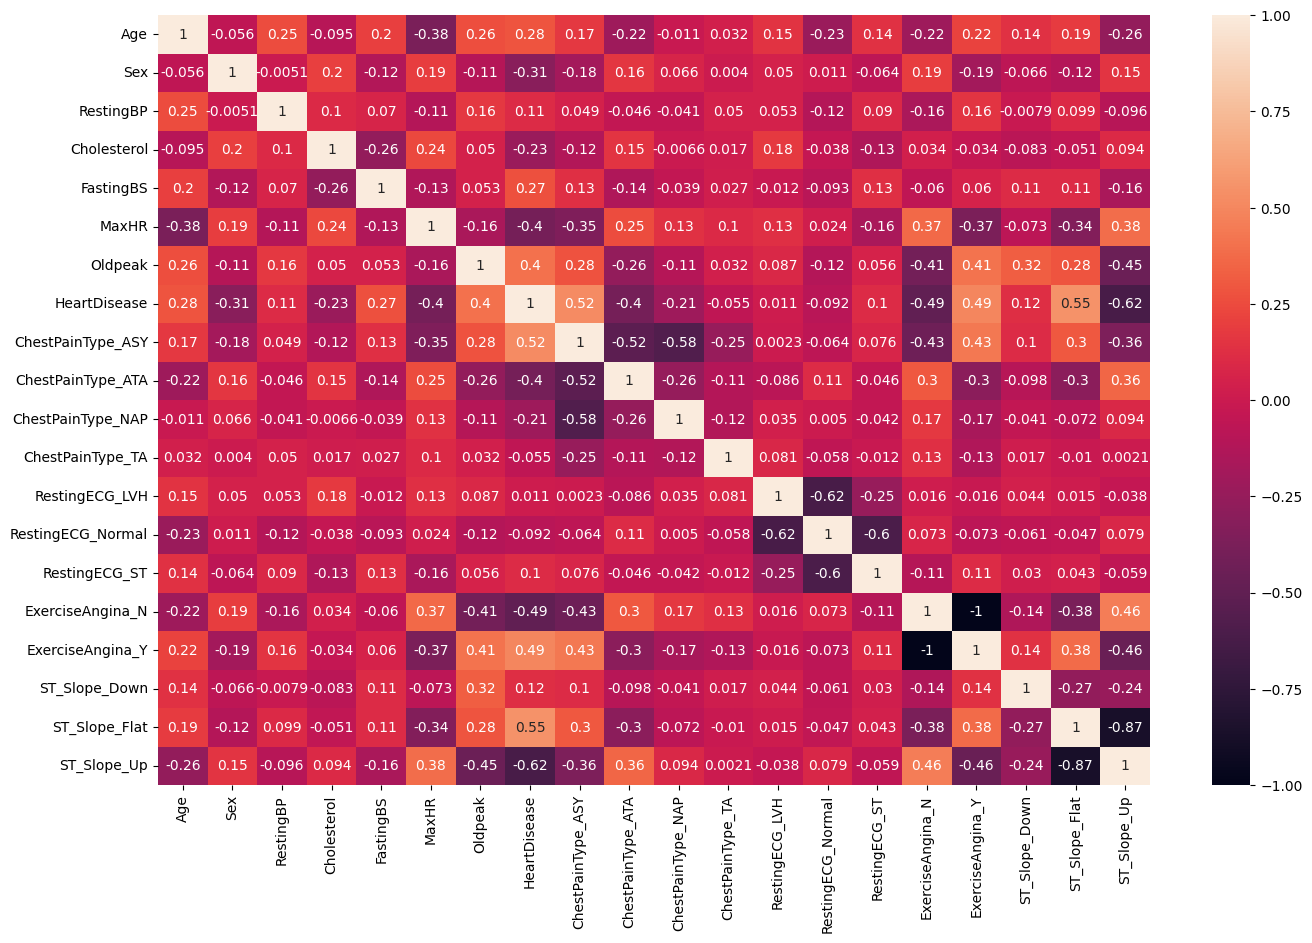

In [39]:
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(), annot=True)

Let's see it in more detail for the target feature - HeartDisease.

In [40]:
df_corr = pd.DataFrame(np.abs(df.corr())).sort_values('HeartDisease', ascending=False)['HeartDisease']

df_corr

,HeartDisease
HeartDisease,1.000000
ST_Slope_Up,0.622164
ST_Slope_Flat,0.554134
ChestPainType_ASY,0.516716
ExerciseAngina_Y,0.494282
ExerciseAngina_N,0.494282
Oldpeak,0.403951
ChestPainType_ATA,0.401924
MaxHR,0.400421
Sex,0.305445


In [41]:
cols = df_corr[df_corr.between(0.45, 0.8)].index.tolist()
cols.append('HeartDisease')

# Dataset 2

In [42]:
df_second = df[pd.Series(cols)]

# Splitting Dataset 1

In [43]:
X = df.drop(['HeartDisease'], axis=1, inplace=False)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

Again, standardising the data to prevent overflow

In [44]:
cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cols.remove('HeartDisease')

std_scaler = StandardScaler()
std_scaler.fit(X_train[cols])

X_train[cols] = std_scaler.transform(X_train[cols])
X_test[cols]  = std_scaler.transform(X_test[cols])

# Applying Logistic Regression on Dataset 1

The Logistic Regression:

In [45]:
class Log_reg:
    def __init__(self, learning_rate = 5e-2, max_iter = 1e+2):
        self.__learning_rate = learning_rate
        self.__max_iter = max_iter

    def sigmoid(self, y):
        return 1 / (1 + np.exp(-y))

    def fit(self, X, y):
        self.weights = np.zeros(len(X[0]) + 1)
        X = np.hstack((X, np.ones((len(X), 1))))

        for i in range(self.__max_iter):
            pred = self.sigmoid(np.dot(X, self.weights))
            gradient = np.dot(X.T, (pred - y)) / y.size
            self.weights -= gradient * self.__learning_rate

        return self

    def predict_proba(self, X):
        X = np.hstack((X, np.ones((len(X), 1))))
        prob = self.sigmoid(np.dot(X, self.weights))
        return np.hstack(((1 - prob).reshape(-1, 1), prob.reshape(-1, 1)))

    def predict(self, X):
        X = np.hstack((X, np.ones((len(X), 1))))
        return (self.sigmoid(np.dot(X, self.weights)) > 0.5) * 1

In [46]:
logr1 = LogisticRegression(max_iter=500)

logr1.fit(X_train, y_train)

y_pred = logr1.predict(X_test)

print(f'Accuracy score: {accuracy_score(y_test.values, y_pred)}')
print(f'Precision score: {precision_score(y_test.values, y_pred)}')
print(f'F1 score: {f1_score(y_test.values, y_pred)}')
print(f'Recall score: {recall_score(y_test.values, y_pred)}')

Accuracy score: 0.8532608695652174
Precision score: 0.9
F1 score: 0.8695652173913043
Recall score: 0.8411214953271028


In [47]:
logr2 = Log_reg(max_iter=2000)

logr2.fit(X_train.values, y_train.values)

y_pred = logr2.predict(X_test.values)

print(f'Accuracy score: {accuracy_score(y_test.values, y_pred)}')
print(f'Precision score: {precision_score(y_test.values, y_pred)}')
print(f'F1 score: {f1_score(y_test.values, y_pred)}')
print(f'Recall score: {recall_score(y_test.values, y_pred)}')

Accuracy score: 0.8532608695652174
Precision score: 0.9
F1 score: 0.8695652173913043
Recall score: 0.8411214953271028


The score is the same for both models - sklearn one and from-scratch.

# Splitting Dataset 2

In [48]:
X = df_second.drop(['HeartDisease'], axis=1, inplace=False)
y = df_second['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

(No need to encode as all values are binary)

In [49]:
cols = df_second.select_dtypes(include=['int64', 'float64']).columns.tolist()
cols.remove('HeartDisease')

std_scaler = StandardScaler()
std_scaler.fit(X_train[cols])

X_train[cols] = std_scaler.transform(X_train[cols])
X_test[cols]  = std_scaler.transform(X_test[cols])

# Applying Logistic Regression on Dataset 2

In [50]:
logr1 = LogisticRegression(max_iter=500)

logr1.fit(X_train, y_train)

y_pred = logr1.predict(X_test)

print(f'Accuracy score: {accuracy_score(y_test.values, y_pred)}')
print(f'Precision score: {precision_score(y_test.values, y_pred)}')
print(f'F1 score: {f1_score(y_test.values, y_pred)}')
print(f'Recall score: {recall_score(y_test.values, y_pred)}')

Accuracy score: 0.8097826086956522
Precision score: 0.9285714285714286
F1 score: 0.8167539267015707
Recall score: 0.7289719626168224


In [51]:
logr2 = Log_reg(max_iter=500)

logr2.fit(X_train.values, y_train.values)

y_pred = logr2.predict(X_test.values)

print(f'Accuracy score: {accuracy_score(y_test.values, y_pred)}')
print(f'Precision score: {precision_score(y_test.values, y_pred)}')
print(f'F1 score: {f1_score(y_test.values, y_pred)}')
print(f'Recall score: {recall_score(y_test.values, y_pred)}')

Accuracy score: 0.8097826086956522
Precision score: 0.9285714285714286
F1 score: 0.8167539267015707
Recall score: 0.7289719626168224


Overall, from-scratch implementation is as good as sklearn one!

After leaving only highly correlated features, the perfrmance has dropped. It is due to the fact that even though there are more features that don't correlate so much with target, but they still provide useful information when combined with other features

What does the recall score mean?

Recall measures the model’s ability to correctly identify positive cases. In our experiments, the dataset containing all features achieved higher recall, meaning that it correctly detected a larger proportion of actual positive cases compared to the dataset with only highly correlated features.

What about precision score?

Precision measures how many of the predicted positive cases were actually correct. Interestingly, the precision score decreased only slightly when using only highly correlated features, indicating that the model still made relatively accurate positive predictions despite having fewer input features.

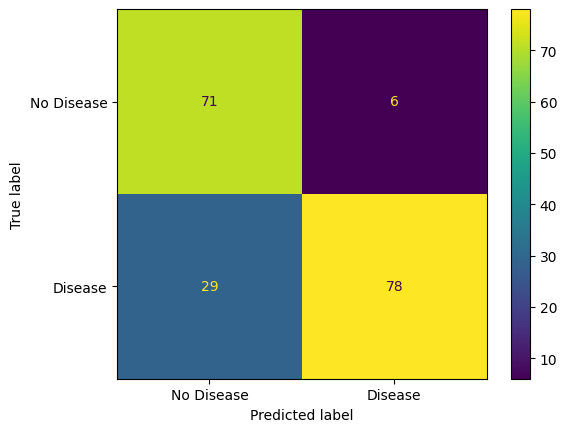

In [52]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['No Disease', 'Disease']
)

disp.plot()
plt.show()

As we see, a pretty large amount of diseases(26/81+26) was missed.

# Tuning Logistic Regression for Recall 1.0

In [53]:
class Log_reg:
    def __init__(self, learning_rate = 5e-2, max_iter = 1e+2):
        self.__learning_rate = learning_rate
        self.__max_iter = max_iter

    def sigmoid(self, y):
        return 1 / (1 + np.exp(-y))

    def fit(self, X, y):
        self.weights = np.zeros(len(X[0]) + 1)
        X = np.hstack((X, np.ones((len(X), 1))))

        for i in range(self.__max_iter):
            pred = self.sigmoid(np.dot(X, self.weights))
            gradient = np.dot(X.T, (pred - y)) / y.size
            self.weights -= gradient * self.__learning_rate

        return self

    def predict_proba(self, X):
        X = np.hstack((X, np.ones((len(X), 1))))
        prob = self.sigmoid(np.dot(X, self.weights))
        return np.hstack(((1 - prob).reshape(-1, 1), prob.reshape(-1, 1)))

    def predict(self, X):
        X = np.hstack((X, np.ones((len(X), 1))))
        return (self.sigmoid(np.dot(X, self.weights)) >= 0.1) * 1

In [54]:
logr2 = Log_reg(max_iter=500)

logr2.fit(X_train.values, y_train.values)

y_pred = logr2.predict(X_test.values)

print(f'Accuracy score: {accuracy_score(y_test.values, y_pred)}')
print(f'Precision score: {precision_score(y_test.values, y_pred)}')
print(f'F1 score: {f1_score(y_test.values, y_pred)}')
print(f'Recall score: {recall_score(y_test.values, y_pred)}')

Accuracy score: 0.8206521739130435
Precision score: 0.7846153846153846
F1 score: 0.8607594936708861
Recall score: 0.9532710280373832


By lowering the classification threshold for predicting heart disease to 0.082, the model achieved a recall of 0.95, meaning that almost all positive cases were correctly identified. However, this adjustment significantly reduced the accuracy score, as the model produced a number of false positive predictions. This highlights the trade-off between recall and accuracy when modifying the decision threshold.

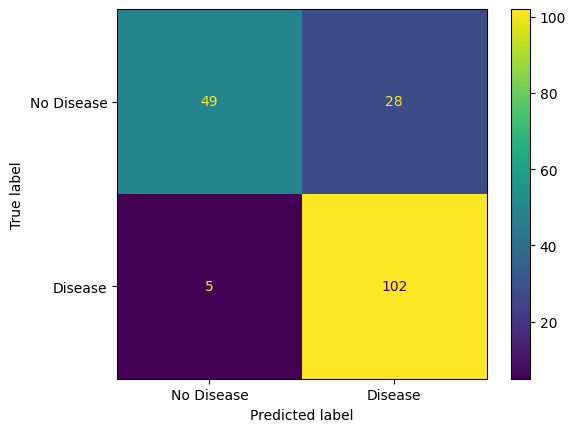

In [55]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['No Disease', 'Disease']
)

disp.plot()
plt.show()

While some people are still labelled as with disease despite not having it, the majority of the people with disease were found - great!

# Tuning Logistic Regression for Recall 1.0

Create again the dataset with all features.

In [56]:
X = df.drop(['HeartDisease'], axis=1, inplace=False)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [57]:
cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cols.remove('HeartDisease')

std_scaler = StandardScaler()
std_scaler.fit(X_train[cols])

X_train[cols] = std_scaler.transform(X_train[cols])
X_test[cols]  = std_scaler.transform(X_test[cols])

Fixing threshold of logistic regression.

In [58]:
class Log_reg:
    def __init__(self, learning_rate = 5e-2, max_iter = 1e+2):
        self.__learning_rate = learning_rate
        self.__max_iter = max_iter

    def sigmoid(self, y):
        return 1 / (1 + np.exp(-y))

    def fit(self, X, y):
        self.weights = np.zeros(len(X[0]) + 1)
        X = np.hstack((X, np.ones((len(X), 1))))

        for i in range(self.__max_iter):
            pred = self.sigmoid(np.dot(X, self.weights))
            gradient = np.dot(X.T, (pred - y)) / y.size
            self.weights -= gradient * self.__learning_rate

        return self

    def predict_proba(self, X):
        X = np.hstack((X, np.ones((len(X), 1))))
        prob = self.sigmoid(np.dot(X, self.weights))
        return np.hstack(((1 - prob).reshape(-1, 1), prob.reshape(-1, 1)))

    def predict(self, X):
        X = np.hstack((X, np.ones((len(X), 1))))
        return (self.sigmoid(np.dot(X, self.weights)) >= 0.16) * 1

In [59]:
logr2 = Log_reg(max_iter=500)

logr2.fit(X_train.values, y_train.values)

y_pred = logr2.predict(X_test.values)

print(f'Accuracy score: {accuracy_score(y_test.values, y_pred)}')
print(f'Precision score: {precision_score(y_test.values, y_pred)}')
print(f'F1 score: {f1_score(y_test.values, y_pred)}')
print(f'Recall score: {recall_score(y_test.values, y_pred)}')

Accuracy score: 0.8478260869565217
Precision score: 0.816
F1 score: 0.8793103448275862
Recall score: 0.9532710280373832


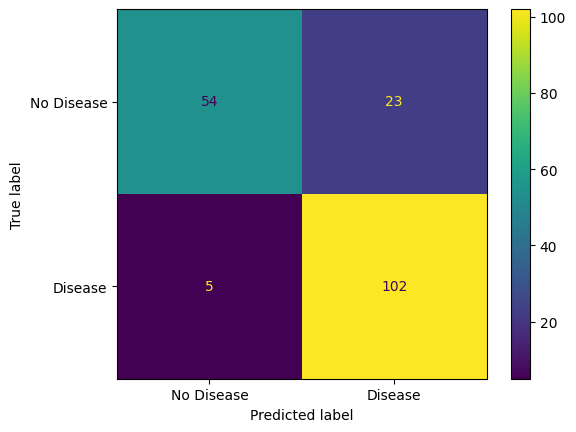

In [60]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['No Disease', 'Disease']
)

disp.plot()
plt.show()

A little better in comparison with only highly correlated features!